In [301]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

plt.style.use(["science","bright","grid"])

In [302]:
def run_magic_cable(time_steps, voltages, topology_parameter, radius=1e5, eq_steps=0):

    np_info2 = {
        'np_index'      : [topology_parameter["Nx"]-1], 
        'mean_radius'   : radius,
        'std_radius'    : 0.0
    }

    target_electrode    = len(topology_parameter["e_pos"])-1
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, np_info2=np_info2)
    sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode,
                               stat_size=20, save=False, eq_steps=eq_steps)
    results             = sim_class.return_output_values()

    return results

In [274]:
radius      = 1e5 #1e5
results     = []
N_min       = 3
N_max       = 16
N_vals      = np.arange(N_min, N_max+1, 1)
N_voltages  = 201
U_input     = np.linspace(0, 0.1, N_voltages, endpoint=True)

for N_p in N_vals:

    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],
                               [N_p-1,0,0],[0,(N_p-1)//2,0],
                               [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],
                               [N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant',
                               'constant','constant',
                               'constant','constant',
                               'constant','floating']
    }

    # Voltage Paramter
    time_step       = 1e-7
    time_steps      = np.arange(N_voltages)*time_step
    voltages        = np.zeros(shape=(N_voltages,(len(topology_parameter['e_pos'])+1)))
    voltages[:,0]   = U_input
    
    val = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results.append(val)

In [280]:
x_vals  = U_input[1:]*1000
df      = 1000*pd.DataFrame(np.array([arr[:,2] for arr in results]).T, columns=N_vals**2)
df_e    = 1000*pd.DataFrame(np.array([arr[:,3] for arr in results]).T, columns=N_vals**2)

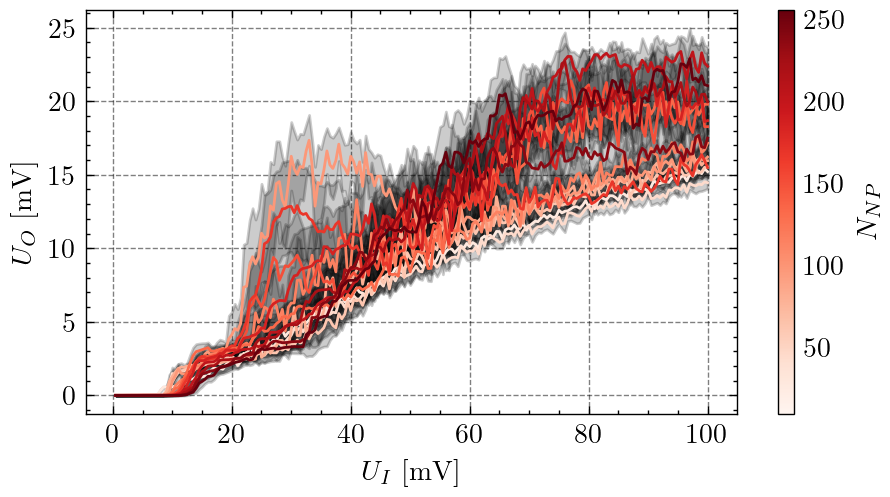

In [282]:
cmap    = plt.get_cmap("Reds")
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)

for i, (col, arr) in enumerate(df.items()):

    ax.plot(x_vals, arr.values, c=cmap((i+1)/len(N_vals)))
    ax.fill_between(x_vals, arr.values-df_e[col].values, arr.values+df_e[col].values,
                    color='black', alpha=0.2)

ax.set_xlabel("$U_I$ [mV]")
ax.set_ylabel("$U_O$ [mV]")

norm    = mpl.colors.Normalize(vmin=N_min**2, vmax=N_max**2)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cbar, ax=ax, label='$N_{NP}$', aspect=25)

In [277]:
def synthetic_bootstrap(arr: np.array, error: np.array, n_synthetic_samples = 1000, n_boot = 100000):

    N_data              = len(arr)
    synthetic_data      = np.zeros(shape=(n_synthetic_samples,N_data))
    bootstrap_sample    = np.zeros(shape=(n_boot,N_data))

    for i, (loc, scale) in enumerate(zip(arr, error)):
        synthetic_data[:,i]     = np.random.normal(loc=loc, scale=scale, size=n_synthetic_samples)
        bootstrap_sample[:,i]   = np.random.choice(synthetic_data[:,i], size=n_boot, replace=True)

    arr_new     = np.mean(bootstrap_sample, axis=0)
    error_new   = np.std(bootstrap_sample, axis=0)

    return arr_new, error_new

In [278]:
arr     = results[13][:,2].copy()
error   = results[13][:,3].copy()

arr_new, error_new  = synthetic_bootstrap(arr, error)

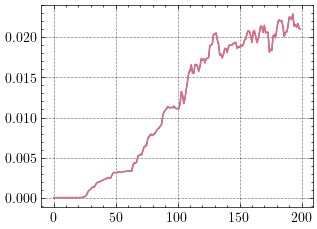

In [279]:
plt.plot(arr)
plt.plot(arr_new)

In [ ]:
N_p = 7

# Network Topology
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                           [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],[0,N_p-1,0],
                           [N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
}
np_info = {
    "eps_r"         : 2.6, 
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

In [283]:
# Parameter
N_samples   = 500
N_procs     = 10
amplitude   = 0.1
freq        = 1.0
time_step   = 1e-7
N_voltages  = 1000
time_steps  = time_step*np.arange(N_voltages)
N_controls  = len(topology_parameter["e_pos"])-2
index       = [i for i in range(N_samples)]
rows        = [index[i::N_procs] for i in range(N_procs)]

In [285]:
from pyDOE import lhs

In [286]:
def return_lhs_sample(pmin, pmax, N_controls, N_samples):

    p_range     = [[pmin,pmax] for _ in range(N_controls)]
    lhs_sample  = lhs(N_controls, N_samples)
    lhs_rescale = np.zeros_like(lhs_sample)

    for i in range(N_controls):
        lhs_rescale[:,i] = p_range[i][0] + lhs_sample[:, i] * (p_range[i][1] - p_range[i][0])

    return lhs_rescale

In [287]:
arr = return_lhs_sample(-0.1,0.1,6,100)

In [294]:
arr      = np.column_stack((arr,np.zeros(100)))
arr      = np.column_stack((np.full(100,0.1),arr))